# Analysis with simulated data

The first part of this code generates some curves for the IRT model and compares the mean of the curves with the position obtained by Resin.

The second part instead analyses how the force-directed algorithm places "in the right place" every node.

In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import winsound 
import scipy.stats as stt
import networkx as nx

### Functions

In [2]:
def expfun(x,a,b):
    fun = np.exp(a*(x-b)) / (1+ np.exp(a*(x-b)) )
    return fun

In [3]:
def gauss(x,mu,sig):
    f = np.exp(-((x-mu)/sig)**2)
    return f

# Main code

Generate the people with different opinions (or equivalently, different values of latent variable)

In [8]:
# define the space
dx = 0.01
x_min = 0
x_max = 10
x = np.arange(x_min,x_max+dx,dx)

p_val = 1/(x_max-x_min)

# Normal p
mup = (x_max-x_min)/2
sigp = 6
p = np.exp(-((x-mup)/sigp)**2)
p = p /(np.sum(p)*dx)

Generate the curves for each item

In [9]:
# Generate the question # CONTINUUM
N_quest = 8
N_ans = 5

ff = [] # vector containing all the functions
mu_v = []
b_v = []
max_v = []

min_diff = 10/N_ans*0.2 # multiply by something smaller than 1

for q in range(0,N_quest): # for each question
    f = []
    
    finito = False
    while not finito:
        a = np.random.rand(N_ans)*0+1
        b = np.array(sorted(np.random.rand(N_ans)*8+1))
        
        d = np.abs(b[0:-1]-b[1:])
        if min(d) > min_diff:
            finito = True
    
    for i in range(0,N_ans):
        if i == N_ans-1 :
            fi = expfun(x,a[i],b[i])
        else:
            fi = expfun(x,a[i],b[i]) - expfun(x,a[i+1],b[i+1])
            
        fi[fi<0] = 0
        
        f.append(fi)
        
    # renormalize the probability
    for i,xi in enumerate(x):
        tot = 0 
        for fi in f:
            tot += fi[i]
        for fi in f:
            fi[i] = fi[i]/tot
        
    bt = []
    mut = []
    maxt = []
    for fi in f: # calculate mu and b
        bi = np.sum(fi*p*dx)
        mu = np.sum(x*fi*dx)*p_val/bi
        
        x_max = x[fi == max(fi)]
        if not type(x_max)==type(x[0]): # if I collected more tha 1 value
            x_max = x_max[0]
        
        bt.append(bi)
        mut.append(mu)
        maxt.append(x_max)
        
    ff.append(f)
    b_v.append(bt)
    mu_v.append(mut)
    max_v.append(maxt)

Show a couple of them

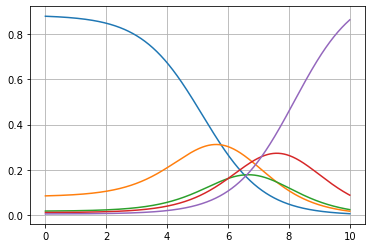

In [11]:
# display one set of functions
for f in ff[0]:
    plt.plot(x,f)
    plt.grid()

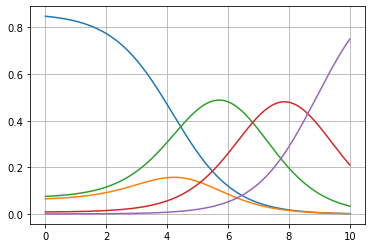

In [12]:
# display one set of functions
for f in ff[-1]:
    plt.plot(x,f)
plt.grid()

Calculate I and phi

In [13]:
def phi_f(x,y1,y2,p):
    n11 = np.sum(y1*y2*p)*dx
    n10 = np.sum(y1*(1-y2)*p)*dx
    n01 = np.sum(y2*(1-y1)*p)*dx
    n00 = np.sum((1-y1)*(1-y2)*p)*dx

    n1_ = np.sum(y1*p)*dx
    n0_ = np.sum((1-y1)*p)*dx
    n_1 = np.sum(y2*p)*dx
    n_0 = np.sum((1-y2)*p)*dx

    num = n11*n00 - n10*n01
    den = n1_ * n0_ * n_1 * n_0
    
    phi = num / np.sqrt(den)
    
    return phi

Make the graph

In [14]:
G = nx.Graph()

C = []

W_v = []

for i1,fq1 in enumerate(ff):
    for i2,fq2 in enumerate(ff):
        
        if i1 <= i2: # skip if you already calculated the question
            pass
        
        for j1,fa1 in enumerate(fq1): # for each answer
            n1 = "q"+str(i1)+"_a"+str(j1)
            if not n1 in G.nodes():
                G.add_node(n1)
            
            for j2,fa2 in enumerate(fq2): # for each answer
                n2 = "q"+str(i2)+"_a"+str(j2)
                if not n2 in G.nodes():
                    G.add_node(n2)
                    
                # calculate the properties
                I = np.sum(fa1*fa2*p)*dx

                b1 = np.sum(fa1*p)*dx
                b2 = np.sum(fa2*p)*dx
                
                phi = phi_f(x,fa1,fa2,p)
                C.append(phi)
                
                gamm = I / (b1*b2)
                
                weight = phi ################# metrics

                W_v.append(weight)
                
                if (not np.isnan(weight)) and (phi>0):
                    G.add_weighted_edges_from([(n1,n2,weight)])

Calculate the position of each node

In [15]:
pos = nx.spring_layout(G,iterations=5000)

In [16]:
pos2 = [[],[]]
key_list = []
for key in pos:
    pos2[0].append(pos[key][0])
    pos2[1].append(pos[key][1])
    key_list.append(key)
#     pos2[2].append(pos[key][1])
    
# print(pos2)

In [17]:
pos3 = []
for key in pos:
    pos3.append([pos[key][0],pos[key][1]])
#     pos2[2].append(pos[key][1])
    
# print(pos3)

Rotate the network so that the main axis is parallel to the x-axis

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=2)
pca.fit(pos3)
x_pca = pca.transform(pos3)

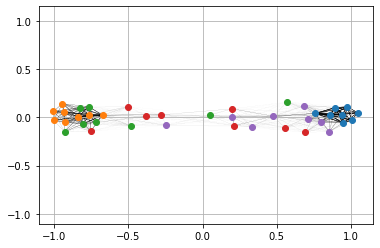

In [20]:
plt.figure()
xx = x_pca[:,0]
yy = x_pca[:,1]

mm = min(xx)*1.1
MM = max(xx)*1.1


koef = 3
for i1, key1 in enumerate(key_list):
    for i2, key2 in enumerate(key_list):
        if (key1, key2) in G.edges:
            w = G.get_edge_data(key1,key2)['weight']
#             print(w)

            if w > 0.:
                plt.plot([xx[i1],xx[i2]],[yy[i1],yy[i2]],'k',linewidth=koef*w**2,zorder=1)

index = np.array(range(0,len(xx)))+1
for a in range(0,N_ans):
    m = np.remainder(index,N_ans) == a
    plt.scatter(xx[m],yy[m],zorder=2)

plt.xlim([mm, MM])
plt.ylim([mm, MM])
plt.grid()

Get the relationship between curve's mean and the position of the nodes in the network

SpearmanrResult(correlation=0.9975609756097563, pvalue=1.5024719649981928e-45)
(0.9588272453615716, 2.2491508246243595e-22)


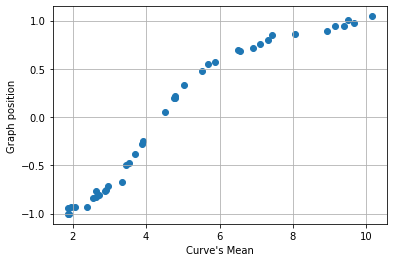

In [21]:

x_ord = []
mu_ord = []
max_ord = []

for i, key in enumerate(key_list):
    q = int(key.split("_")[0][1:])
    a = int(key.split("_")[1][1:])
    
    mu = mu_v[q][a]
    mx = max_v[q][a]
    
    x_ord.append(xx[i])
    mu_ord.append(mu)
    max_ord.append(mx)
    
plt.figure()
plt.scatter(mu_ord,x_ord)
plt.grid()
plt.ylabel("Graph position")
plt.xlabel("Curve's Mean")
    
print(stt.spearmanr(mu_ord,x_ord))
print(stt.pearsonr(mu_ord,x_ord))

# Simulation of force directed system

This is the simulation used to generate figure 5

In [22]:
def force(x,mu,m):
    
    M = 1
    s = 2.5*M  # the value 2.5 comes from the graphs of how phi relates to distance
    
    dist = np.abs(m-mu)
    k = M-s*dist
    if k < 0:
        k = 0
    
    delta = (np.abs(x-m))**2
    
    ff = -k*delta*np.sign(x-m)
    
    return ff

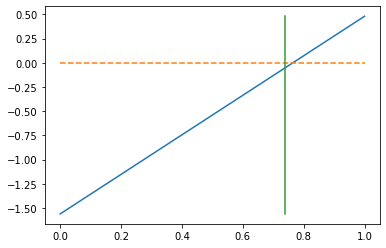

In [24]:
dx = 0.001
x_min = 0
x_max = 1
x = np.arange(x_min,x_max+dx,dx)

min_dist1 = 0.2
min_dist2 = 0.2

finito = False

while not finito:
    m1 = np.random.rand()
    m2 = np.random.rand()

    if np.abs(m1-m2) < min_dist1:
        finito = True


mu = min([m1,m2])+(np.random.rand()*(max([m1,m2])-min([m1,m2])))

t1 = lambda x : (1-mu+m1)*(x-m1)
t2 = lambda x : (1-mu+m2)*(x-m2)

f = t1(x)+t2(x)

plt.plot(x,f)
plt.plot([0,1],[0,0],'--')
plt.plot([mu,mu],[min(f),max(f)])

Repetition version

0.08154974506655611
SpearmanrResult(correlation=0.9945602094935665, pvalue=0.0)


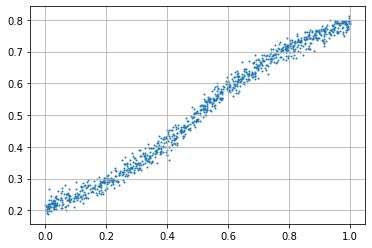

In [25]:
N_rep = 1000

N_m = 50

dd = []

dx = 0.001
x_min = 0
x_max = 1
x = np.arange(x_min,x_max+dx,dx)

mu_v_real = []
mu_v_est = []

for i in range(0,N_rep):

    m_vec = 0.1 + 0.8*np.random.rand(N_m)

    mu = np.random.rand()

    f = x*0
    for m in m_vec:
        f = f + force(x,mu,m)

    mu_est = x[np.abs(f) == min(np.abs(f))]
    mu_est = mu_est[0]
    
    d = mu_est-mu
    
    dd.append(d)
    mu_v_real.append(mu)
    mu_v_est.append(mu_est)
    
dd = np.array(dd)
std = np.sqrt(np.sum(dd**2)/len(dd))
avg_err = np.mean(np.abs(dd))

print(avg_err)
print(stt.spearmanr(mu_v_real,mu_v_est))

plt.scatter(mu_v_real,mu_v_est,s=1)
plt.grid()